In [12]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.image import imread
import os
import sys



import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [13]:
from noslice import *

In [14]:
# spatial transcriptomics data
count = pd.read_csv("./data/Filtered/filtered_ST_matrix_and_meta_data/filtered_matrix.tsv",
                    sep="\t", index_col=0).T

meta = pd.read_csv("./data/Filtered/filtered_ST_matrix_and_meta_data/meta_data.tsv",
                   sep="\t", index_col=0)

genes_new = pd.read_csv("./data/genes_new.txt")
count.columns = list(genes_new.x.values)

count = count.loc[:, count.columns.notna()]

In [15]:
adata_st_list_raw = []

for i in range(1, 10):
    count_i = count[[loc.split("x")[0]==str(i+4) for loc in count.index]]
    count_i.index = [(loc.split("x")[1]+"x"+loc.split("x")[2]) for loc in count_i.index]
    meta_i = meta[[loc.split("x")[0]==str(i+4) for loc in meta.index]]
    meta_i.index = [(loc.split("x")[1]+"x"+loc.split("x")[2]) for loc in meta_i.index]

    loc_i = pd.read_csv("./data/ST_Samples_6.5PCW/ST_Sample_6.5PCW_%d/spot_data-all-ST_Sample_6.5PCW_%d.tsv" % (i, i),
                       sep="\t")

    loc_i.index = [(str(loc_i.x.values[k]) + 'x' + str(loc_i.y.values[k])) for k in range(loc_i.shape[0])]
    loc_i = loc_i.loc[meta_i.index]

    img_i = imread('./data/ST_Samples_6.5PCW/ST_Sample_6.5PCW_%d/ST_Sample_6.5PCW_%d_HE_small.jpg' % (i, i))

    adata_st_i = ad.AnnData(X = count_i.values)

    adata_st_i.obs = meta_i
    adata_st_i.obs['selected'] = loc_i['selected'].values
    adata_st_i.var.index = count_i.columns

    library_id = '0'
    adata_st_i.uns["spatial"] = dict()
    adata_st_i.uns["spatial"]['0'] = dict()
    adata_st_i.uns["spatial"]['0']['images'] = dict()
    adata_st_i.uns["spatial"]['0']['images']['hires'] = img_i
    adata_st_i.uns["spatial"]['0']['scalefactors'] = {'spot_diameter_fullres': 100,
                                                      'tissue_hires_scalef': 1.0,
                                                      'fiducial_diameter_fullres': 100,
                                                      'tissue_lowres_scalef': 1.0}

    adata_st_i.obsm['spatial'] = np.concatenate((loc_i['pixel_x'].values.reshape(-1, 1),
                                                 loc_i['pixel_y'].values.reshape(-1, 1)), axis=1)

    adata_st_i.obsm['loc_use'] = np.concatenate((loc_i['x'].values.reshape(-1, 1),
                                                 loc_i['y'].values.reshape(-1, 1)), axis=1)

    adata_st_i.obs['array_row'] = loc_i['y'].values
    adata_st_i.obs['array_col'] = loc_i['x'].values

    adata_st_i = adata_st_i[adata_st_i.obs['selected'].values != 0]
    adata_st_list_raw.append(adata_st_i.copy())

In [16]:
# single-cell reference data
count_ref = pd.read_csv("./data/Filtered/share_files/all_cells_count_matrix_filtered.tsv",
                        sep='\t', index_col=0).T

meta_ref = pd.read_csv("./data/Filtered/share_files/all_cells_meta_data_filtered.tsv",
                        sep='\t', index_col=0)

adata_ref = ad.AnnData(X = count_ref.values)
adata_ref.obs.index = count_ref.index
adata_ref.var.index = count_ref.columns
for col in meta_ref.columns[:-1]:
    adata_ref.obs[col] = meta_ref.loc[count_ref.index][col].values

In [17]:
count_ref = pd.read_csv("./data/Filtered/share_files/all_cells_count_matrix_filtered.tsv",
                        sep='\t', index_col=0).T

meta_ref = pd.read_csv("./data/Filtered/share_files/all_cells_meta_data_filtered.tsv",
                        sep='\t', index_col=0)

adata_ref = ad.AnnData(X = count_ref.values)
adata_ref.obs.index = count_ref.index
adata_ref.var.index = count_ref.columns
for col in meta_ref.columns[:-1]:
    adata_ref.obs[col] = meta_ref.loc[count_ref.index][col].values

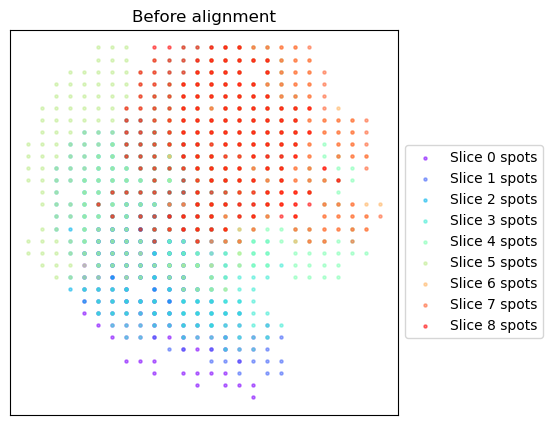

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


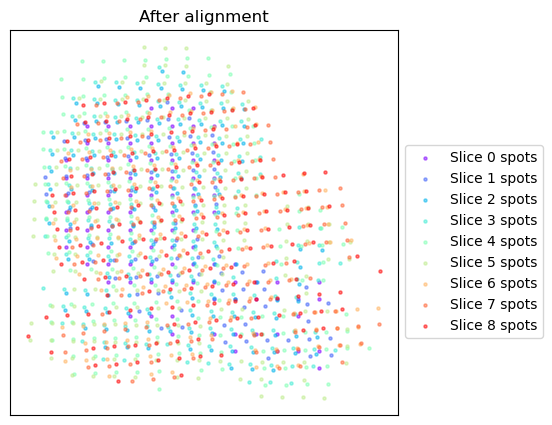

In [18]:
adata_st_list = noslice.utils.align_spots(adata_st_list_raw, data_type = "ST", coor_key="loc_use", test_all_angles=True, plot=True)

In [19]:
adata_st, adata_basis = noslice.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  sample_col="experiment",
                                                  rad_cutoff=1.1, c2c_dist=200., coor_key="loc_use",
                                                  slice_dist_micron=[5., 115., 85., 160.,
                                                                     5., 160., 5., 155.,],
                                                  n_hvg_group=500)

Finding highly variable genes...
3837 highly variable genes selected.
Calculate basis for deconvolution...
2 batches are used for computing the basis vector of cell type <Atrial cardiomyocytes>.
2 batches are used for computing the basis vector of cell type <Capillary endothelium>.
2 batches are used for computing the basis vector of cell type <Cardiac neural crest cells >.
2 batches are used for computing the basis vector of cell type <Endothelium / pericytes >.
2 batches are used for computing the basis vector of cell type <Epicardial cells>.
2 batches are used for computing the basis vector of cell type <Epicardium-derived cells>.
2 batches are used for computing the basis vector of cell type <Erythrocytes>.
2 batches are used for computing the basis vector of cell type <Fibroblast-like >.
1 batches are used for computing the basis vector of cell type <Immune cells>.
2 batches are used for computing the basis vector of cell type <Myoz2-enriched cardiomyocytes>.
1 batches are used fo

In [20]:
model = noslice.model.Model(adata_st, adata_basis, training_steps = 2000)

model.train(step_interval=100)

  0%|          | 2/2000 [00:00<04:00,  8.29it/s]

Step: 0, Loss: 168.2959, d_loss: 162.5888, f_loss: 57.0703


  5%|▌         | 102/2000 [00:11<03:31,  8.97it/s]

Step: 100, Loss: -553.1491, d_loss: -556.4594, f_loss: 33.1027


 10%|█         | 202/2000 [00:21<02:47, 10.74it/s]

Step: 200, Loss: -685.4652, d_loss: -688.7404, f_loss: 32.7517


 15%|█▌        | 301/2000 [00:32<02:46, 10.23it/s]

Step: 300, Loss: -780.6480, d_loss: -783.9036, f_loss: 32.5558


 20%|██        | 401/2000 [00:42<02:26, 10.88it/s]

Step: 400, Loss: -852.2314, d_loss: -855.4740, f_loss: 32.4254


 25%|██▌       | 502/2000 [00:52<02:29,  9.99it/s]

Step: 500, Loss: -905.8181, d_loss: -909.0507, f_loss: 32.3254


 30%|███       | 601/2000 [01:02<02:13, 10.47it/s]

Step: 600, Loss: -943.8661, d_loss: -947.0909, f_loss: 32.2475


 35%|███▌      | 702/2000 [01:14<03:30,  6.16it/s]

Step: 700, Loss: -971.7364, d_loss: -974.9524, f_loss: 32.1600


 40%|████      | 801/2000 [01:25<02:16,  8.81it/s]

Step: 800, Loss: -990.1952, d_loss: -993.4056, f_loss: 32.1043


 45%|████▌     | 901/2000 [01:36<01:49, 10.07it/s]

Step: 900, Loss: -1004.2178, d_loss: -1007.4197, f_loss: 32.0193


 50%|█████     | 1001/2000 [01:47<02:02,  8.17it/s]

Step: 1000, Loss: -1013.8899, d_loss: -1017.0822, f_loss: 31.9226


 55%|█████▌    | 1101/2000 [01:59<01:29, 10.05it/s]

Step: 1100, Loss: -1021.2628, d_loss: -1024.4462, f_loss: 31.8342


 60%|██████    | 1202/2000 [02:09<01:30,  8.79it/s]

Step: 1200, Loss: -1026.9999, d_loss: -1030.1713, f_loss: 31.7135


 65%|██████▌   | 1303/2000 [02:20<01:06, 10.43it/s]

Step: 1300, Loss: -1029.6720, d_loss: -1032.8354, f_loss: 31.6350


 70%|███████   | 1403/2000 [02:31<01:00,  9.82it/s]

Step: 1400, Loss: -1034.2357, d_loss: -1037.3877, f_loss: 31.5194


 75%|███████▌  | 1502/2000 [02:42<00:56,  8.79it/s]

Step: 1500, Loss: -1036.8594, d_loss: -1040.0018, f_loss: 31.4245


 80%|████████  | 1602/2000 [02:53<00:42,  9.29it/s]

Step: 1600, Loss: -1038.7850, d_loss: -1041.9146, f_loss: 31.2955


 85%|████████▌ | 1702/2000 [03:03<00:30,  9.81it/s]

Step: 1700, Loss: -1040.3562, d_loss: -1043.4741, f_loss: 31.1788


 90%|█████████ | 1801/2000 [03:13<00:19, 10.37it/s]

Step: 1800, Loss: -1041.6484, d_loss: -1044.7546, f_loss: 31.0626


 95%|█████████▌| 1903/2000 [03:23<00:09,  9.84it/s]

Step: 1900, Loss: -1042.6716, d_loss: -1045.7649, f_loss: 30.9324


100%|██████████| 2000/2000 [03:34<00:00,  9.34it/s]


In [21]:
save_path = "./results/human_heart/batch_noslice"

result = model.eval(adata_st_list_raw, save=True, output_path=save_path)

In [22]:
# save adata_st
model.adata_st.write_h5ad(save_path + "/model.adata_st.h5ad")

In [23]:
sc.pp.neighbors(model.adata_st, use_rep='latent', n_neighbors=30)
sc.tl.louvain(model.adata_st, resolution=0.5)

model.adata_st.obs["louvain"].to_csv(os.path.join(save_path, "clustering_result.csv"))

In [24]:
for i, adata_st_i in enumerate(result):
    adata_st_i.obs["louvain"] = model.adata_st.obs.loc[adata_st_i.obs_names, ]["louvain"]

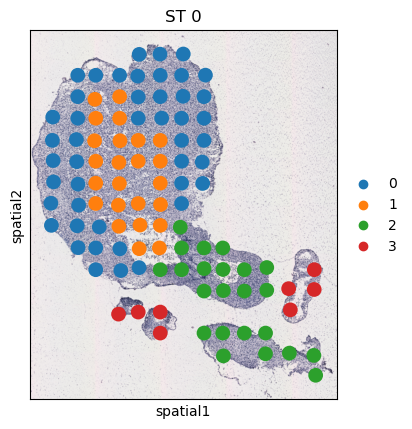

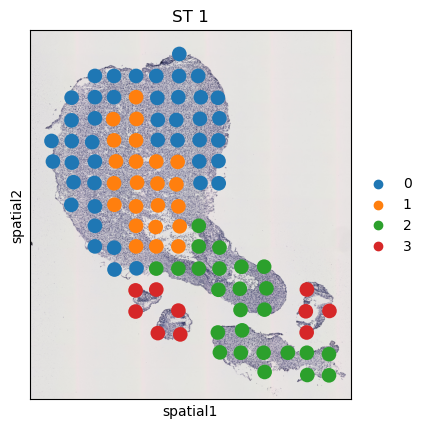

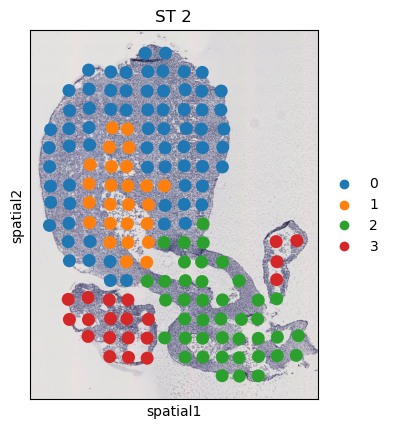

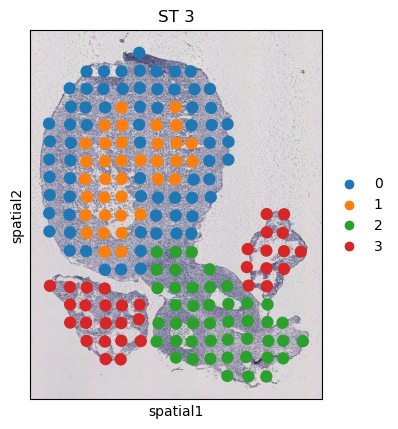

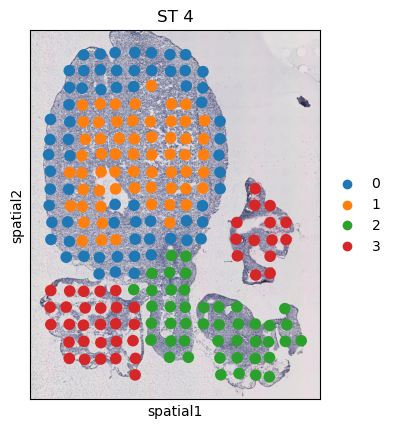

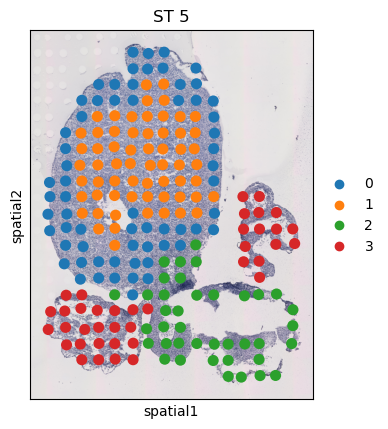

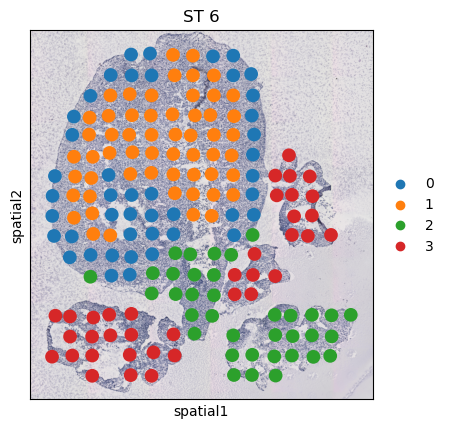

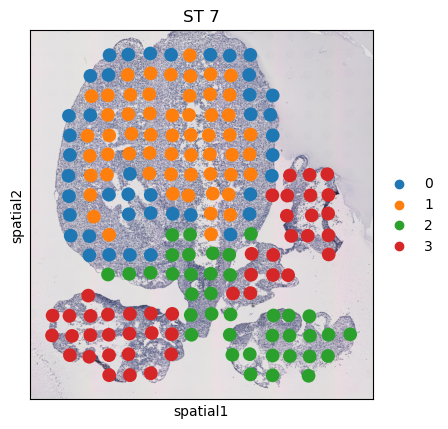

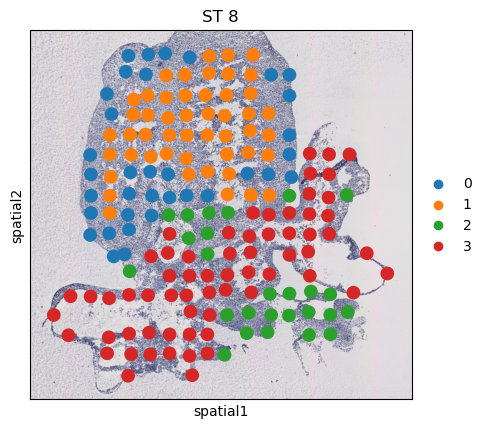

In [26]:
for i, adata_st_i in enumerate(result):
    sc.pl.spatial(result[i], img_key="hires", color=["louvain"], size=1.5, title="Slice %d" % (i),)